In [19]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy, numpy as np
from livelossplot import PlotLosses
from train_model import train_model
%matplotlib inline

In [28]:
from multiprocessing import Pool

if __name__ == '__main__':
    p = Pool(64)
    start = time.time()
    
    train_val = ['train', 'train_noise']
    
    tr = train_val[1]
    cat_path = '/disk/LHC/images/64/' + tr + '/'
    save_cat_path = '/disk/LHC/images/71_60to70/' + tr + '/'
    cat_list = os.listdir(cat_path)
    for cat in cat_list:
        p.apply_async(randomized_layer, (tr, cat_path, cat, save_cat_path, ))
    p.close()
    p.join()
    p.terminate()
            
    end = time.time()

print(end-start)
                

448.3079557418823


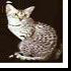

In [25]:
a = '/disk/LHC/images/71_60to70/train/000/images/n02124075_276_65_3_3.png'
im = Image.open(a)
im

In [26]:
from PIL import Image, ImageOps
import random

def randomized_layer(tr, cat_path, cat, save_cat_path):
    
    if 'noise' in tr:
        folder_path = cat_path + cat + '/'
    else:
        folder_path = cat_path + cat + '/images/'
    save_folder_path = save_cat_path + cat + '/'
    image_list = os.listdir(folder_path)

    for image in image_list:
        image_path = folder_path + image
        im = Image.open(image_path)
        new_size = (71, 71)
        
        for a in range(60,70):
            img = im.resize((a,a), Image.ANTIALIAS)
            old_size = img.size
            for i in range(10):
                new_im = Image.new("RGB", new_size) 
                rand_value_1 = random.randint(0,round((new_size[0]-old_size[0])/2))
                rand_value_2 = random.randint(0,round((new_size[0]-old_size[0])/2))
                new_im.paste(img, (rand_value_1, rand_value_2))
                tmp_file_name = image.split('.')[0]
                file_name = tmp_file_name + '_' +str(a) + '_' + str(rand_value_1) + '_' + str(rand_value_2) + '.png'
                new_im.save(save_folder_path + file_name) 
#         os.remove(image_path)



In [ ]:
image_path = '/disk/MTJ/images/64/train_noise/000/8.png'
image = '8.png'

In [ ]:
im = Image.open(image_path)
a = random.randint(64,70)
img = im.resize((a,a), Image.ANTIALIAS)
old_size = img.size
new_size = (71, 71)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(img, (random.randint(0,round((new_size[0]-old_size[0])/2)), random.randint(0,round((new_size[0]-old_size[0])/2))))
tmp_file_name = image.split('.')[0]
file_name = tmp_file_name + '_' + str(a) + '_' + str(round((new_size[0]-old_size[0])/2)) + '.png'
# new_im.save(folder_path + file_name)   
print(file_name)
new_im

In [ ]:
round((new_size[0]-old_size[0])/2)

In [ ]:
new_size = (71, 71)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(img, (random.randint(0,round((new_size[0]-old_size[0])/2)), random.randint(0,round((new_size[0]-old_size[0])/2))))
new_im

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'aug1': transforms.Compose([
        transforms.RandomResizedCrop()
        transforms.RandomHorizontalFlip(1),
        transforms.ToTensor()
    ]),
    'aug2': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ]),
#     'aug3': transforms.Compose([
#         transforms.RandomCrop(224),
#         transforms.ToTensor()
#     ]),
#     'aug4': transforms.Compose([
#         transforms.RandomCrop(224),
#         transforms.RandomHorizontalFlip(1),
#         transforms.ToTensor()
#     ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

train_datasets =  datasets.ImageFolder('/disk/MTJ/images/64/train', data_transforms['train'])
augmt1_datasets = datasets.ImageFolder('/disk/MTJ/images/64/train', data_transforms['aug1'])
augmt2_datasets = datasets.ImageFolder('/disk/MTJ/images/64/train', data_transforms['aug2'])
# augmt3_datasets = datasets.ImageFolder('tiny-imagenet-200-256/train', data_transforms['aug3'])
# augmt4_datasets = datasets.ImageFolder('tiny-imagenet-200-256/train', data_transforms['aug4'])
valid_datasets =  datasets.ImageFolder('/disk/MTJ/images/64/val',   data_transforms['val'])

concat = torch.utils.data.ConcatDataset([
    train_datasets,
    augmt1_datasets,
    augmt2_datasets,
#     augmt3_datasets,
#     augmt4_datasets,
])

dataloaders = {
    'train' : torch.utils.data.DataLoader(concat, batch_size=100, shuffle=True, num_workers=64),
    'val'   : torch.utils.data.DataLoader(valid_datasets, batch_size=100, shuffle=True, num_workers=64)
}

dataset_sizes = {
    'train' : len(concat),
    'val'   : len(valid_datasets)
}

In [ ]:
#Load Resnet18 with pretrained weights
model_ft = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
model_ft.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model_ft.maxpool = nn.Sequential()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
#Multi GPU
# model_ft = torch.nn.DataParallel(model_ft, device_ids=[0, 1])
#Load 256x256 tiny-imagenet trained ResNet18
pretrained_dict = torch.load('/disk/MTJ/models/resnet18_256_normalized.pt')
model_ft_dict = model_ft.state_dict()

#Reset 1st layer weight
first_layer_weight = model_ft_dict['module.conv1.weight']
first_layer_bias  = model_ft_dict['module.conv1.bias']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_ft_dict}

model_ft_dict.update(pretrained_dict) 
model_ft_dict['module.conv1.weight'] = first_layer_weight
model_ft_dict['module.conv1.bias']   = first_layer_bias

#Load pretrained weight from layer 2~18
model_ft.load_state_dict(model_ft_dict)


#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#Train
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
torch.save(model_ft.state_dict(), "./models/resnet18_256_64.pt") 

In [ ]:
torch.save(model_ft, "./models/resnet18_64_full_model.pt")

In [ ]:
model_ft = torch.load("./models/resnet18_64_full_model.pt")

In [ ]:
from test_model import test_model

data_transforms = {
    'val': transforms.Compose([
        transforms.ToTensor(),
    ])
}
valid_datasets =  datasets.ImageFolder('./64/val_noise/',   data_transforms['val'])
dataloaders = {
    'val'   : torch.utils.data.DataLoader(valid_datasets, batch_size=100, shuffle=True, num_workers=0)
}
dataset_sizes = {
    'val'   : len(valid_datasets)
}
#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#Test
test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
model_ft = torch.load("./models/resnet18_64_full_model.pt")
data_transforms = {
    'val': transforms.Compose([
        transforms.ToTensor(),
    ])
}
valid_datasets =  datasets.ImageFolder('./tiny-imagenet-200/val',   data_transforms['val'])
dataloaders = {
    'val'   : torch.utils.data.DataLoader(valid_datasets, batch_size=100, shuffle=True, num_workers=0)
}
dataset_sizes = {
    'val'   : len(valid_datasets)
}
#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#Test
test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)